# Strain stratification

Summer provides a special disease-strain stratification class ([StrainStratification](http://summerepi.com/api/stratification.html#summer.stratification.StrainStratification)) that treats each stratum as a separate strain of the infection. This allows you to model multiple strains of an infection (or multiple infectious diseases with similar compartmental structures) which are able to infect people separately.

They key difference between StrainStratification vs. a normal Stratification is that the strain stratification adjusts the count of infectious people per strain. For example, in a normal stratification with an age-based split into 'young' and 'old' you will have frequency-dependent infection flows calculated as follows:

```python
# Find a common force of infection for both young and old
num_infected = num_old_infected + num_young_infected
force_of_infection = contact_rate * num_infected / num_pop

# Use that common force of infection to get flow rates for young/old infection 
infect_rate_young = force_of_infection * num_young_susceptible
infect_rate_old = force_of_infection * num_old_susceptible
```

Consider now how this will be calculated for two strains ("mild" and "wild") when applied to an unstratified susceptible compartment:

```python
# Find a different force of infection for mild and wild
force_of_infection_mild = contact_rate * num_infected_mild / num_pop
force_of_infection_wild = contact_rate * num_infected_wild / num_pop

# Use the different force of infection values to get flow rates for mild/wild infection 
infect_rate_mild = force_of_infection_mild * num_susceptible
infect_rate_wild = force_of_infection_wild * num_susceptible
```

Let's work through a code example. For starters, let's create an SIR model:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from summer import CompartmentalModel

def build_model():
    """Returns a model for the stratification examples"""
    model = CompartmentalModel(
        times=[1990, 2010],
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )

    # Add people to the model
    model.set_initial_population(distribution={"S": 990, "I": 10})

    # Susceptible people can get infected.
    model.add_infection_frequency_flow(name="infection", contact_rate=2, source="S", dest="I")

    # Infectious people take 3 years, on average, to recover.
    model.add_transition_flow(name="recovery", fractional_rate=1/3, source="I", dest="R")

    # Add an infection-specific death flow to the I compartment.
    model.add_death_flow(name="infection_death", death_rate=0.05, source="I")
    return model

    
def plot_compartments(model):
    """Plot model compartment sizes over time"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
    for i in range(model.outputs.shape[1]):
        ax.plot(model.times, model.outputs.T[i])
        
    ax.set_title("SIR Model Outputs")
    ax.set_xlabel("Year")
    ax.set_ylabel("Compartment size")
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start + 1, end, 5))
    ax.legend([str(c) for c in model.compartments], loc='upper right')
    plt.show()
    print('Compartment names:', model.compartments)
    print('Initial values:', model.outputs[0])
    print('Final values:', model.outputs[-1])

# Force NumPy to format output arrays nicely. 
np.set_printoptions(formatter={'all': lambda f: f"{f:0.2f}"})

Lets see what this model looks like without any stratifications:

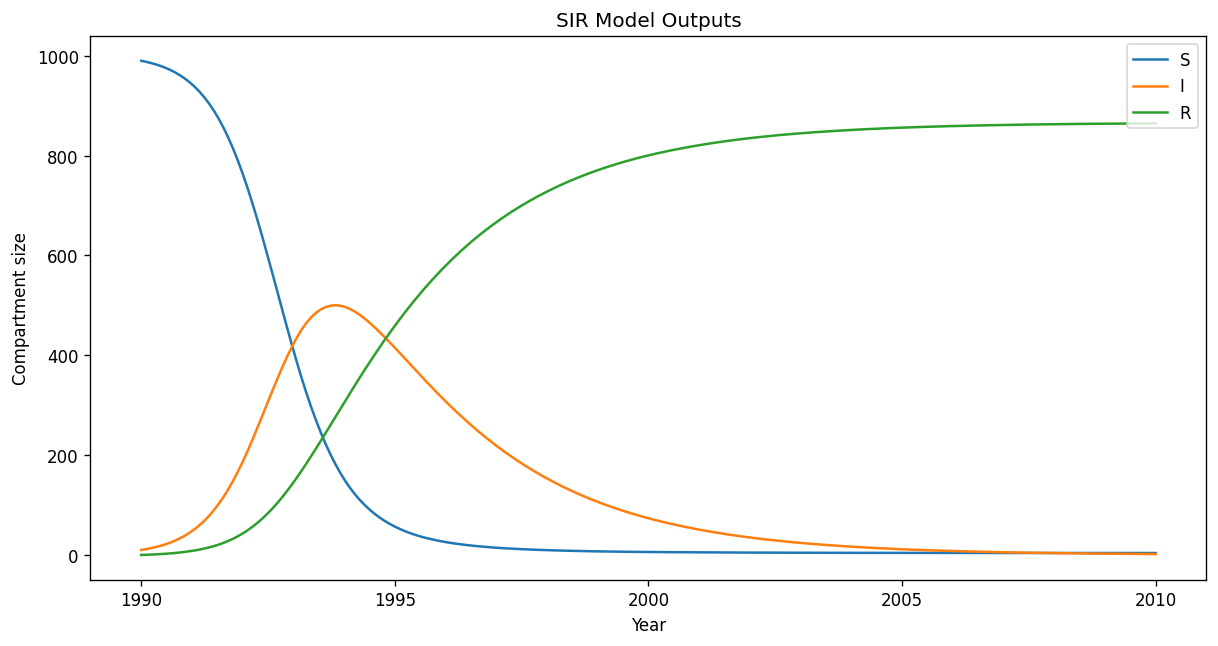

Compartment names: [S, I, R]
Initial values: [990.00 10.00 0.00]
Final values: [3.87 1.76 864.67]


In [2]:
model = build_model()
model.run()
plot_compartments(model)

Now we can add a strain stratification to the infected (I) and recovered (R) compartments. We will assume immunity to one strain gives you immunity to the other.

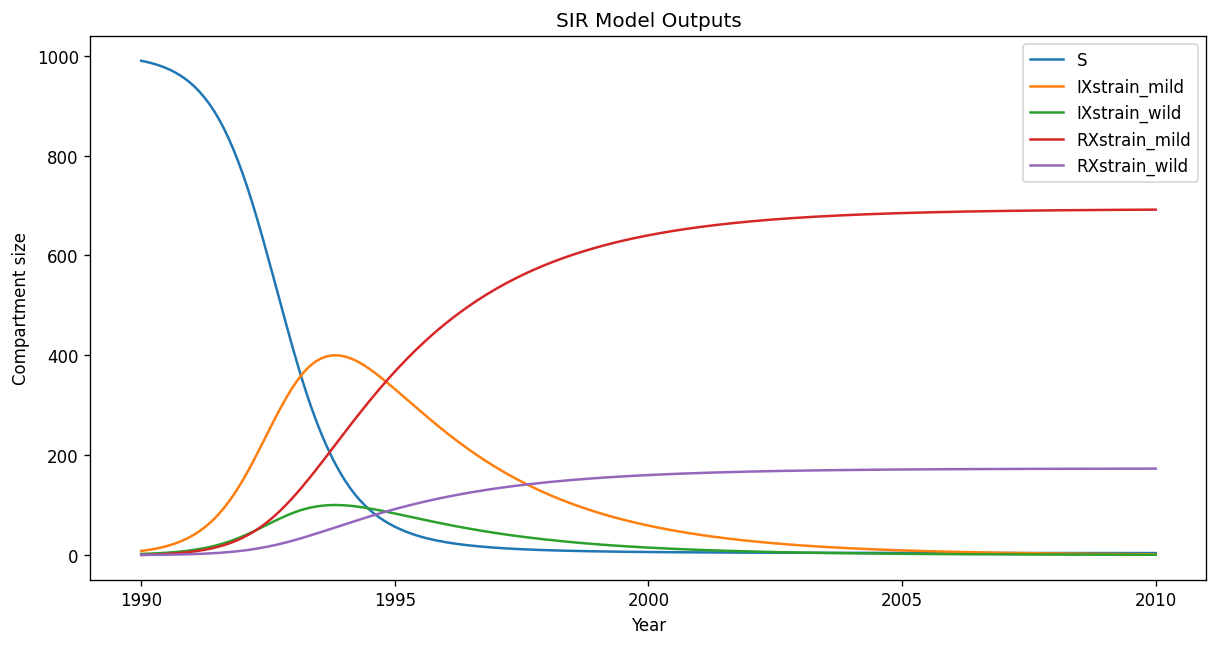

Compartment names: [S, IXstrain_mild, IXstrain_wild, RXstrain_mild, RXstrain_wild]
Initial values: [990.00 8.00 2.00 0.00 0.00]
Final values: [3.79 1.41 0.35 691.79 172.95]


In [3]:
from summer import StrainStratification

strata = ['mild', 'wild']
strat = StrainStratification(name="strain", strata=strata, compartments=['I', 'R'])

# At the start of the simulation, 20% of infected people have wild strain.
strat.set_population_split({'mild': 0.8, 'wild': 0.2})

model = build_model()
model.stratify_with(strat)
model.run()
plot_compartments(model)

Note that despite the stratification, the model results are the same in aggregate, because we have not applied any adjustments to the flows or strata infectiousness yet. Let's do that: 

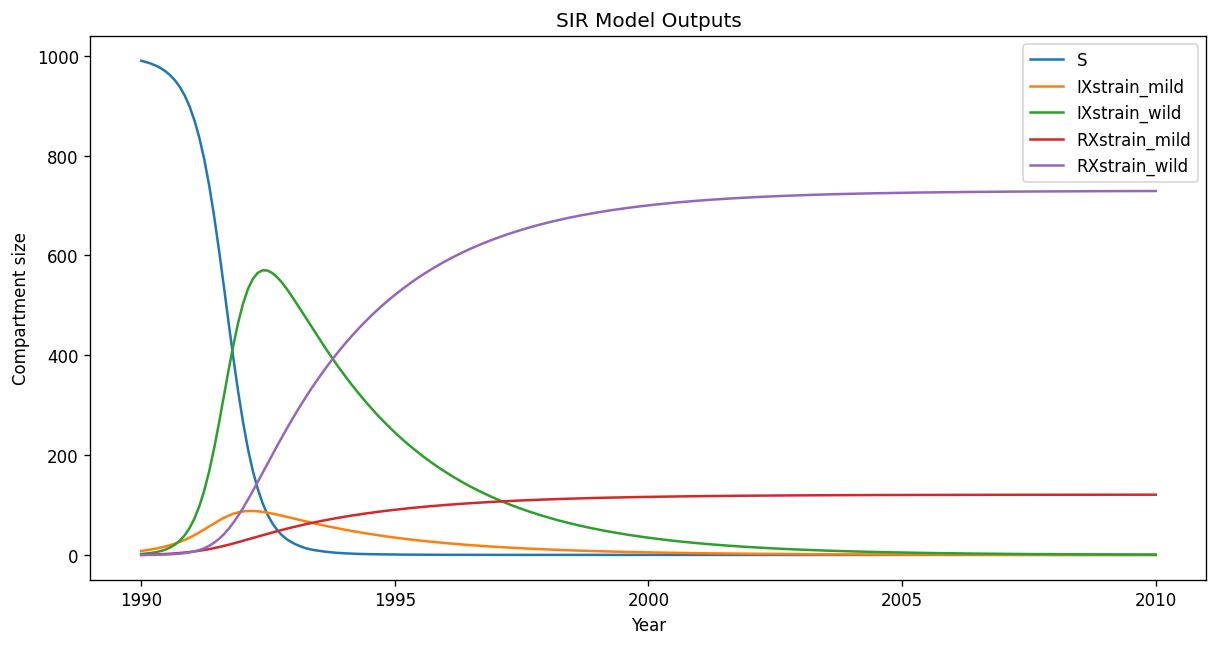

Compartment names: [S, IXstrain_mild, IXstrain_wild, RXstrain_mild, RXstrain_wild]
Initial values: [990.00 8.00 2.00 0.00 0.00]
Final values: [0.04 0.11 0.68 120.75 729.07]


In [4]:
from summer import StrainStratification, Multiply

strata = ['mild', 'wild']
strat = StrainStratification(name="strain", strata=strata, compartments=['I', 'R'])

# Again, 20% of infected people have wild strain at the start.
strat.set_population_split({'mild': 0.8, 'wild': 0.2})

# The wild strain kills at 1.2x the rate as the mild strain does.
strat.add_flow_adjustments("infection_death", {
    "mild": None,  
    "wild": Multiply(1.2),
})


# Wild strain is twice as infectious than the mild strain (or equivalently, people are twice as susceptible to it).
strat.add_flow_adjustments("infection", {
    "mild": None,  
    "wild": Multiply(2),
})


model = build_model()
model.stratify_with(strat)
model.run()
plot_compartments(model)